In [1]:
from gensim import corpora, models, similarities
import logging
import pprint
import pandas as pd
import time
import wordcloud
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
import ast
import random

In [2]:
dictionary = corpora.Dictionary.load("data/dictionary.dict")

In [3]:
# Number of topics
n = 100

In [4]:
def _applyTopicScores(corpus, trainedModel):
    """
    For a given corpus (that has already been vectorised), create x columns, where each column is
    the score for a given topic. 
    Input:
        Corpus: a dataframe with all the topics
        trainedModel: a trained LDA model with the appropriate number of topics
    Output:  
        Corpus with topic scores
    """
    
    # Create the topic score columns
    for i in range(n):
        corpus["topic_{}_score".format(i)] = 0.0 # float init
        
    
    # Score each document
    for i in corpus.index:
        try:
            scores = trainedModel.get_document_topics(corpus.iloc[i]["text_vec"])
            for topic in scores:
                corpus.at[i, "topic_{}_score".format(topic[0])] = topic[1]
                
        except:
            corpus.drop(i, inplace=True)
            
    print(len("{} columns after scoring".format(corpus.columns)))
    return corpus

In [5]:
def _generateSentimentScaledTopicScores(scoredCorpus):
    """
    Create an extra column for each topic, which is the topic weight * sentiment
    Input:
        scoredCorpus: a corpus which has already ben scored
    Output: 
        Corpus with sentiment scores 
    """
    cols = [x for x in scoredCorpus.columns if "topic_" in x]
    for col in cols:
        scoredCorpus["{}_sentiment".format(col)] = scoredCorpus[col].apply(np.ceil) * scoredCorpus["sentiment"]
    return scoredCorpus

In [6]:
def _getTopicRankings(scoredCorpus):
    """
    For a given SCORED corpus, rank the individual topics by popularity.
    Input:
        scoredCorpus
    Output: 
        a list of topics, sorted by most popular
    """
    topicCols = [x for x in scoredCorpus if ("topic_" in x) and ("sentiment" not in x)]
    print("aggregating and ranking {} topic's scores".format(len(topicCols)))
    topicScores = []
    if len(topicCols) == 0:
        print("NO TOPIC SCORES")
        return
    for col in topicCols:
        topicScores.append([col[:-6], np.mean(scoredCorpus[col]), int(col[6:-6])])
        
    topicScores.sort(key=lambda x: x[1], reverse=True)
    return topicScores

In [7]:
def _getTopNWords(n, topicNum, model, dictionary):
    """
    Get the top N words from a given topic.
    Returns a list of n * [word, score]
    Input:
        n: how many words
        topicNum: index of topic that we need to get the words from
        model: trained LDA mode
        dictionary: gensim dictionary matching LDA model
    Output: 
    """
    top = model.get_topic_terms(topicid=topicNum, topn=n)
    newTop = []
    for i in top:
        # Convert to list so we can overwrite
        iList = list(i)
        iList[0] = dictionary.get(iList[0])
        newTop.append(iList)
    return newTop

In [8]:
def _writeWordCloudsFromTopicWords(topicWords):
    """
    Input:
        list of words with associated weights
    Output: 
        JPG file of a wordcloud
    """
    date = dt.datetime.now()
    dateString = "{}-{}-{}".format(date.day, date.month, date.year)
    
    for top in range(len(topicWords)):
        topicName = topicWords[top][0]
        scaled = topicWords[top][1]

        # Scale the probabilites to a large enough int (simulate a frequency)
        scaled = [[x[0], int(x[1]*100000)] for x in scaled]

        # Store all the mock frequencies in a dict
        freqDict = {}
        for w in scaled:
            freqDict[w[0]] = w[1]

        wc = wordcloud.wordcloud.WordCloud(stopwords = set(["it"])) # placeholder stopword list
        wc.generate_from_frequencies(freqDict)
        
        wc.to_file("wordclouds/{}_{}.jpg".format(topicName, dateString))

In [100]:
def _getTopicWords(model, scoredCorpus, dictionary, topNTopics):
    """
    Return the top 10 words from every topic in a large object.
    Input:
        model: trained LDA model
        scoredCorpus: corpus with popularity and sentiment ranking
        dictionary: gensim dict
        topNTopics: integer value, how many topics to analyse
    Output: 
    """
    topicRankings = _getTopicRankings(scoredCorpus)
    
    topicWords = []
    for i in range(topNTopics):
        # Get the number of the topic
        topicN = int(topicRankings[i][0].split("_")[1])
        
        # Get the top words from that topic
        thisTopicWords = _getTopNWords(10, topicN, model, dictionary)
        
        # currently just take the top 10 words
        topicWords.append([topicRankings[i][0], [x for x in thisTopicWords]])
    return topicWords
    

In [10]:
def getTopicSentimentRanked(scoredCorpus):
    """
    Get a ranked list of each topic and it's weighted average sentiment score.
    Input:
        scoredCorpus: corpus with popularity and sentiment ranking
    Output:
        A list of topics, each wtih the mean sentiment
    """
    meanSentiments = []
    cols = [x for x in scoredCorpus.columns if "_sentiment" in x]
    
    # Get the mean topic-scaled sentiment across the corpus
    for col in cols:
        topicN = int(col.split("_")[1])
        meanSentiment = np.mean(scoredCorpus[col])
        meanSentiments.append(["topic_{}".format(topicN), meanSentiment, topicN])
    
    meanSentiments = sorted(meanSentiments, key=lambda x: x[1], reverse=True)
    return meanSentiments

In [11]:
def getTopicPopularityRanked(scoredCorpus):
    """
    Get a ranked list of each topic and it's weighted average sentiment score.
    Input:
        scoredCorpus: corpus with popularity and sentiment ranking
    Output: 
        A list of topics, each wtih the mean popularity, i.e. "how much was this topic talked about"
    """
    meanPopularities = []
    cols = [x for x in scoredCorpus.columns if ("_sentiment" not in x) and ("topic" in x)]
    
    # Get the mean topic-scaled sentiment across the corpus
    for col in cols:
        topicN = int(col.split("_")[1])
        meanPopularity = np.mean(scoredCorpus[col])
        meanPopularities.append(["topic_{}".format(topicN), meanPopularity, topicN])
    
    meanPopularities = sorted(meanPopularities, key=lambda x: x[1], reverse=True)
    return meanPopularities

In [12]:
def printTopXofNTopics(result, x, n, bottom=False):
    """
    Input:
        result: A ranked list of topics
        x: number of words to print
        n: number of topics
        bottom: bool, print the bottom n?
    Output: 
        stdout print
    """
    
    elementsToLoopThrough = result[:n]
    if bottom:
        elementsToLoopThrough = result[-n:]
    
    # RANKED topics (sentiment)
    for i in elementsToLoopThrough:
        topicN = i[2]
        print("===",i)
        top = m.get_topic_terms(topicid=topicN, topn=x)
        for word in top:
            print("\t",dictionary.get(word[0]), word[1])

In [13]:
def convertRankedToDf(ranked, metric):
    """
    Convert the scores into dataframe
    Return: Dataframe
    Input:
        ranked: list of [topicname, score, topicN]
        matric: string, to be used in the col header
    Output: dataframe conversion of ranked topics

    """
    df = pd.DataFrame(columns=["name", "n", "{}_score".format(metric)])
    
    # Add each row to the df
    for i in ranked:
        df = df.append({"name":i[0], "n":i[2], "{}_score".format(metric):i[1]}, ignore_index=True)
    
    return df

In [15]:
def getTop10URLs(topicId, corpus, metric):
    """
    Get the 10 URLs that are most strongly associated with a given topic
    Input:
        topicID: the index of the topic 
        corpus: scored corpus
        metric: either "sentiment" or "popularity"
    Output: 
        list of 10 URLs to articles
    """
    if metric == "popularity":
        colName = "topic_{}_score".format(topicId)
    elif metric == "sentiment":
        colName = "topic_{}_score_sentiment".format(topicId)
    
    rankedScores = corpus.sort_values(colName, ascending=False)
    return rankedScores["url"][:10].values

In [95]:
def convertToCommaSep(s):
    return ",".join([x[0] for x in s])

def convertToCommaSepString(s):
    return ",".join([str.strip(x) for x in s])

def convertToCommaSepNum(s):
    return ",".join([str(round(x[1], 4)) for x in s])

In [96]:
def getTopicAnalysisDf(corpus, model, dictionary):
    """
    Main function, this will take a given model/corpus/dictionary and perform all analysis
    Input:
        corpus: corpus of documents
        model: trained LDA model
        dictionary: gensim dict of uniquee terms from corpus
    Output: 
        scoredCorpus: corpus with sentiment and popularity scores applied
        finalDf: DataFrame structured for easy ingestion into Tableau
        topicSentimentRanked: simple ranked list of topics by sentiment
        topicPopularityRanked:  simple ranked list of topics by popularity
    """
    # Apply the topic scores from the trained model
    scoredCorpus = _applyTopicScores(corpus, model)
    scoredCorpus = _generateSentimentScaledTopicScores(scoredCorpus)
    topicSentimentRanked = getTopicSentimentRanked(scoredCorpus)
    topicPopularityRanked = getTopicPopularityRanked(scoredCorpus)
    topicWords = _getTopicWords(m, scoredCorpus, dictionary, 3)

    _writeWordCloudsFromTopicWords(topicWords)
    
    # Create initial dataframes, sort by index of topic id
    topicSentimentDf = convertRankedToDf(topicSentimentRanked, "sentiment").sort_values("n").set_index("n")
    topicPopularityDf = convertRankedToDf(topicPopularityRanked, "popularity").sort_values("n").set_index("n")
    
    finalDf = topicSentimentDf.copy()
    finalDf["popularity"] = topicPopularityDf["popularity_score"]
    
    # Apply functions 
    def getTop10Words(i):
        i = int(i)
        topWords = m.get_topic_terms(topicid=i, topn=10)
        wordScoreList = [(dictionary.get(x[0]), x[1]) for x in topWords]
        return wordScoreList    

    def urlApplyPop(i):
        return getTop10URLs(i, corpus, "popularity")
    
    def urlApplySent(i):
        return getTop10URLs(i, corpus, "sentiment")
    
    # Create 3 new columns
    finalDf["words"] = finalDf.reset_index()["n"].apply(getTop10Words)
    finalDf["wordsSep"] = finalDf["words"].apply(convertToCommaSep)
    finalDf["wordsProbabilities"] = finalDf["words"].apply(convertToCommaSepNum)
    finalDf["topPopularityURLs"] = finalDf.reset_index()["n"].apply(urlApplyPop)
    finalDf["topPopularityURLs"] = finalDf["topPopularityURLs"].apply(convertToCommaSepString)
    finalDf["topSentimentURLs"] = finalDf.reset_index()["n"].apply(urlApplySent)
    finalDf["topSentimentURLs"] = finalDf["topSentimentURLs"].apply(convertToCommaSepString)
    
    return scoredCorpus, finalDf, topicSentimentRanked, topicPopularityRanked

In [97]:
m = models.LdaModel.load("models/lda-{}topics.model".format(n))
corpusRaw = pd.read_csv("data/corpus_df.csv", index_col=0)
corpusRaw["text_lem"] = corpusRaw["text_lem"].apply(ast.literal_eval)
corpusRaw["text_vec"] = corpusRaw["text_vec"].apply(ast.literal_eval)

In [98]:
corpus, finalDf, topicSentimentRanked, topicPopularityRanked = getTopicAnalysisDf(corpusRaw, m, dictionary)

435
aggregating and ranking 100 topic's scores


In [93]:
finalDf.to_csv("finalLDAAnalysis.csv", sep="|")

# The rest of this notebook is not required 

In [99]:
finalDf.head()

,name,sentiment_score,popularity,words,wordsSep,wordsProbabilities,topPopularityURLs,topSentimentURLs
n,,,,,,,,
0,topic_0,0.015619,0.002161,"[(vegan, 0.0680860777988), (hand, 0.0207098294...","vegan,hand,eye,sun,dr,cupcake,plantbased,stree...","0.0681,0.0207,0.0136,0.0135,0.0119,0.0117,0.01...","bit.ly/2HMDGVs,http://www.worldpeacediet.com/f...",www.sassyhongkong.com/the-best-swimwear-stores...
1,topic_1,0.028419,0.005842,"[(test, 0.0527324435821), (surgery, 0.02985877...","test,surgery,patient,will,procedure,result,dis...","0.0527,0.0299,0.0242,0.0187,0.0142,0.014,0.011...",http://www.digestivehealth.org.hk/en_us/health...,righthomeremedies.com/2018/03/04/the-most-powe...
2,topic_2,0.089326,0.028262,"[(day, 0.0213341638118), (weight, 0.0168878707...","day,weight,eat,time,week,lose,make,start,go,work","0.0213,0.0169,0.0162,0.0151,0.0116,0.0115,0.01...","trib.al/f7vA39V,www.stethnews.com/0251/how-muc...",www.sassyhongkong.com/beauty-nail-art-best-sal...
3,topic_3,0.017682,0.003603,"[(bite, 0.0251992704431), (rash, 0.02021589086...","bite,rash,tick,skin,insect,find,plant,bug,home...","0.0252,0.0202,0.0172,0.0146,0.0103,0.0095,0.00...","trib.al/k9KXSCf,trib.al/8DtCU0Q,trib.al/h0N8f0...",www.sassyhongkong.com/beauty-nail-art-best-sal...
4,topic_4,0.028316,0.006279,"[(yoga, 0.0869033047831), (fitness, 0.05117785...","yoga,fitness,class,will,learn,training,people,...","0.0869,0.0512,0.0342,0.0181,0.012,0.012,0.0118...",http://tranceformfitness.com/about-tranceform-...,www.sassyhongkong.com/travel-destinations-moth...


In [53]:
for i in finalDf.sort_values("popularity", ascending=False)["words"][:20]:
    print([x[0] for x in i])
    print()

['say', 'go', 'know', 'time', 'think', 'one', 'want', 'tell', 'make', 'feel']

['use', 'cooky', 'site', 'content', 'policy', 'include', 'term', 'privacy', 'experience', 'medical']

['hong', 'kong', 'sassy', 'offer', 'shop', 'best', 'image', 'city', 'make', 'event']

['say', 'may', 'cause', 'doctor', 'symptom', 'people', 'blood', 'dr', 'accord', 'help']

['day', 'weight', 'eat', 'time', 'week', 'lose', 'make', 'start', 'go', 'work']

['hong', 'kong', 'image', 'courtesy', 'via', 'restaurant', 'offer', 'city', 'new', 'bar']

['body', 'life', 'health', 'mind', 'stress', 'hong', 'kong', 'energy', 'support', 'physical']

['student', 'learn', 'course', 'university', 'education', 'professor', 'learning', 'will', 'hku', 'technology']

['diet', 'fat', 'body', 'food', 'weight', 'eat', 'health', 'sugar', 'help', 'high']

['hong', 'kong', 'take', 'one', 'beach', 'island', 'road', 'city', 'hike', 'wan']

['will', 'cause', 'cold', 'body', 'food', 'stomach', 'water', 'eat', 'time', 'people']

['health

In [94]:
pd.read_csv("finalLDAAnalysis.csv", sep="|")

,n,name,sentiment_score,popularity,words,wordsSep,wordsProbabilities,topPopularityURLs,topSentimentURLs
0,0,topic_0,0.015619,0.002161,"[('vegan', 0.068086077798751907), ('hand', 0.0...","vegan,hand,eye,sun,dr,cupcake,plantbased,stree...","0.0681,0.0207,0.0136,0.0135,0.0119,0.0117,0.01...","bit.ly/2HMDGVs,http://www.worldpeacediet.com/f...",www.sassyhongkong.com/the-best-swimwear-stores...
1,1,topic_1,0.028419,0.005842,"[('test', 0.052732443582145468), ('surgery', 0...","test,surgery,patient,will,procedure,result,dis...","0.0527,0.0299,0.0242,0.0187,0.0142,0.014,0.011...",http://www.digestivehealth.org.hk/en_us/health...,righthomeremedies.com/2018/03/04/the-most-powe...
2,2,topic_2,0.089326,0.028262,"[('day', 0.021334163811783519), ('weight', 0.0...","day,weight,eat,time,week,lose,make,start,go,work","0.0213,0.0169,0.0162,0.0151,0.0116,0.0115,0.01...","trib.al/f7vA39V,www.stethnews.com/0251/how-muc...",www.sassyhongkong.com/beauty-nail-art-best-sal...
3,3,topic_3,0.017682,0.003603,"[('bite', 0.025199270443098099), ('rash', 0.02...","bite,rash,tick,skin,insect,find,plant,bug,home...","0.0252,0.0202,0.0172,0.0146,0.0103,0.0095,0.00...","trib.al/k9KXSCf,trib.al/8DtCU0Q,trib.al/h0N8f0...",www.sassyhongkong.com/beauty-nail-art-best-sal...
4,4,topic_4,0.028316,0.006279,"[('yoga', 0.086903304783144439), ('fitness', 0...","yoga,fitness,class,will,learn,training,people,...","0.0869,0.0512,0.0342,0.0181,0.012,0.012,0.0118...",http://tranceformfitness.com/about-tranceform-...,www.sassyhongkong.com/travel-destinations-moth...
5,5,topic_5,0.027009,0.004652,"[('hair', 0.02250720414178415), ('thyroid', 0....","hair,thyroid,loss,treatment,use,gland,cause,he...","0.0225,0.0223,0.0115,0.0105,0.0097,0.0094,0.00...",www.sassyhongkong.com/eatdrink-cheap-lunch-she...,www.sassyhongkong.com/eatdrink-cheap-lunch-she...
6,6,topic_6,0.014912,0.004263,"[('design', 0.01792093487272451), ('interior',...","design,interior,duff,body,space,liquid,work,sw...","0.0179,0.0164,0.0164,0.0155,0.0107,0.0093,0.00...","http://www.liquid-interiors.com/about/,http://...",www.sassyhongkong.com/living-neigbourhood-guid...
7,7,topic_7,0.077939,0.025222,"[('diet', 0.023598066616049396), ('fat', 0.022...","diet,fat,body,food,weight,eat,health,sugar,hel...","0.0236,0.0225,0.0222,0.0169,0.0168,0.0151,0.01...",www.stethnews.com/0201/the-nutritional-benefit...,righthomeremedies.com/2018/01/21/kill-thyroid-...
8,8,topic_8,0.014327,0.002994,"[('chocolate', 0.042790515432168989), ('color'...","chocolate,color,road,dark,brown,cabbage,look,s...","0.0428,0.0192,0.0166,0.0143,0.0134,0.0132,0.01...","bit.ly/2x0wLSk,trib.al/Z6nkjTr,bit.ly/2rv1xTx,...",www.sassyhongkong.com/eat-drink-best-egg-tarts...
9,9,topic_9,0.020458,0.003314,"[('allergy', 0.044699684243809767), ('honey', ...","allergy,honey,asthma,use,treatment,parsley,al,...","0.0447,0.0267,0.0186,0.0165,0.0118,0.0104,0.00...",http://www.acupuncture.org.uk/arrc/public-revi...,http://www.motherearthnews.com/natural-health/...


In [23]:
corpus.head()

,text_lem,sentiment,url,text_vec,topic_0_score,topic_1_score,topic_2_score,topic_3_score,topic_4_score,topic_5_score,...,topic_90_score_sentiment,topic_91_score_sentiment,topic_92_score_sentiment,topic_93_score_sentiment,topic_94_score_sentiment,topic_95_score_sentiment,topic_96_score_sentiment,topic_97_score_sentiment,topic_98_score_sentiment,topic_99_score_sentiment
0,"[official, name, codonopsis, radix, english, n...",0.6760,http://hyy.com.hk/blog/,"[(0, 4), (1, 16), (2, 3), (3, 2), (4, 4), (5, ...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.000,0.0,0.676,0.0,0.000
1,"[tell, u, story, become, interested, public, h...",0.9809,https://mph.sph.hku.hk/en/alumni/the-alumni-st...,"[(9, 4), (37, 2), (40, 1), (46, 1), (47, 2), (...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.9809,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000
2,"[please, make, sure, enter, valid, complete, n...",0.8910,http://www.charged.hk/?q=user/register,"[(1, 1), (148, 2), (193, 1), (194, 1), (195, 1...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000
3,"[hong, kong, association, organize, event, ele...",0.8316,http://www.charged.hk/node/27,"[(193, 1), (201, 1), (203, 2), (204, 4), (205,...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000
4,"[electric, vehicle, charge, station, pop, ever...",0.7430,http://in.reuters.com/video/2015/07/29/hong-ko...,"[(40, 2), (78, 1), (101, 1), (112, 1), (142, 1...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.743,0.0,0.000,0.0,0.743


In [24]:
corpusRaw

,text_lem,sentiment,url,text_vec,topic_0_score,topic_1_score,topic_2_score,topic_3_score,topic_4_score,topic_5_score,...,topic_90_score_sentiment,topic_91_score_sentiment,topic_92_score_sentiment,topic_93_score_sentiment,topic_94_score_sentiment,topic_95_score_sentiment,topic_96_score_sentiment,topic_97_score_sentiment,topic_98_score_sentiment,topic_99_score_sentiment
0,"[official, name, codonopsis, radix, english, n...",0.6760,http://hyy.com.hk/blog/,"[(0, 4), (1, 16), (2, 3), (3, 2), (4, 4), (5, ...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.6760,0.0,0.000
1,"[tell, u, story, become, interested, public, h...",0.9809,https://mph.sph.hku.hk/en/alumni/the-alumni-st...,"[(9, 4), (37, 2), (40, 1), (46, 1), (47, 2), (...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.9809,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000
2,"[please, make, sure, enter, valid, complete, n...",0.8910,http://www.charged.hk/?q=user/register,"[(1, 1), (148, 2), (193, 1), (194, 1), (195, 1...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000
3,"[hong, kong, association, organize, event, ele...",0.8316,http://www.charged.hk/node/27,"[(193, 1), (201, 1), (203, 2), (204, 4), (205,...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000
4,"[electric, vehicle, charge, station, pop, ever...",0.7430,http://in.reuters.com/video/2015/07/29/hong-ko...,"[(40, 2), (78, 1), (101, 1), (112, 1), (142, 1...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0,0.0,0.7430,0.0,0.0000,0.0,0.743
5,"[traditional, chinese, medicine, tcm, 2000, ye...",0.9974,http://hyy.com.hk/about-traditional-chinese-me...,"[(6, 1), (13, 3), (31, 1), (45, 1), (49, 1), (...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.9974,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000
6,"[select, one, following, topic, learn, chinese...",-0.9349,http://hyy.com.hk/chinese-medicine-info/,"[(13, 4), (26, 1), (73, 1), (90, 1), (135, 1),...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,-0.9349,-0.0000,-0.0000,-0.0,-0.0,-0.0000,-0.0,-0.0000,-0.0,-0.000
7,"[western, physiology, urine, consider, fluid, ...",0.9997,http://hyy.com.hk/about-traditional-chinese-me...,"[(13, 6), (19, 5), (28, 1), (30, 9), (31, 1), ...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.9997,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000
8,"[coriolus, versicolor, know, versicolor, name,...",0.9996,http://hyy.com.hk/about-traditional-chinese-me...,"[(1, 2), (11, 7), (13, 6), (31, 10), (32, 1), ...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000
9,"[mushroom, health, supplement, combine, benefi...",0.9996,http://hyy.com.hk/about-traditional-chinese-me...,"[(1, 2), (6, 1), (11, 8), (13, 13), (31, 17), ...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.9996,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000


In [28]:
topicSentimentRanked

[['topic_55', 0.18965805832693783, 55],
 ['topic_59', 0.11763499616270146, 59],
 ['topic_68', 0.10056143514965463, 68],
 ['topic_2', 0.089326208749040667, 2],
 ['topic_13', 0.08904996162701459, 13],
 ['topic_19', 0.085076976208749044, 19],
 ['topic_63', 0.084081657712970076, 63],
 ['topic_70', 0.082579700690713728, 70],
 ['topic_7', 0.07793860322333078, 7],
 ['topic_45', 0.075874405218726002, 45],
 ['topic_51', 0.075137643898695317, 51],
 ['topic_50', 0.074397313891020722, 50],
 ['topic_37', 0.073652340752110509, 37],
 ['topic_48', 0.072842402148887181, 48],
 ['topic_92', 0.068931197237145053, 92],
 ['topic_91', 0.066838948580199536, 91],
 ['topic_96', 0.065126247122026096, 96],
 ['topic_24', 0.064835955487336908, 24],
 ['topic_98', 0.062689831158864159, 98],
 ['topic_66', 0.061399002302379123, 66],
 ['topic_84', 0.059831465848042983, 84],
 ['topic_41', 0.058977590176515729, 41],
 ['topic_54', 0.058537260168841136, 54],
 ['topic_67', 0.05838741366078281, 67],
 ['topic_83', 0.0572426707

In [30]:
import matplotlib.pyplot as plt

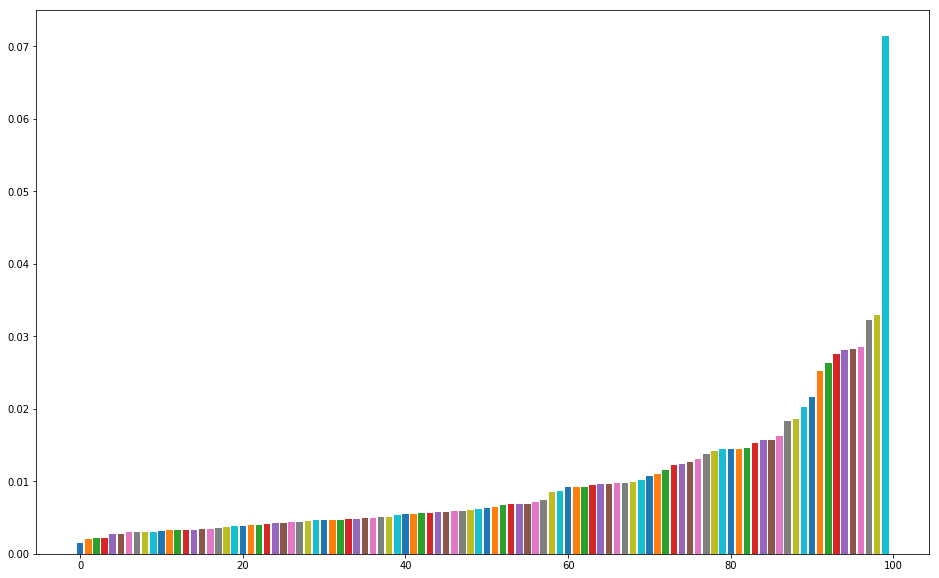

In [57]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
values = finalDf.sort_values("popularity")["popularity"].values

for i in range(len(values)):
    ax.bar(i, values[i])

In [32]:
corpus

,text_lem,sentiment,url,text_vec,topic_0_score,topic_1_score,topic_2_score,topic_3_score,topic_4_score,topic_5_score,...,topic_90_score_sentiment,topic_91_score_sentiment,topic_92_score_sentiment,topic_93_score_sentiment,topic_94_score_sentiment,topic_95_score_sentiment,topic_96_score_sentiment,topic_97_score_sentiment,topic_98_score_sentiment,topic_99_score_sentiment
0,"[official, name, codonopsis, radix, english, n...",0.6760,http://hyy.com.hk/blog/,"[(0, 4), (1, 16), (2, 3), (3, 2), (4, 4), (5, ...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.6760,0.0,0.000
1,"[tell, u, story, become, interested, public, h...",0.9809,https://mph.sph.hku.hk/en/alumni/the-alumni-st...,"[(9, 4), (37, 2), (40, 1), (46, 1), (47, 2), (...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.9809,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000
2,"[please, make, sure, enter, valid, complete, n...",0.8910,http://www.charged.hk/?q=user/register,"[(1, 1), (148, 2), (193, 1), (194, 1), (195, 1...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000
3,"[hong, kong, association, organize, event, ele...",0.8316,http://www.charged.hk/node/27,"[(193, 1), (201, 1), (203, 2), (204, 4), (205,...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000
4,"[electric, vehicle, charge, station, pop, ever...",0.7430,http://in.reuters.com/video/2015/07/29/hong-ko...,"[(40, 2), (78, 1), (101, 1), (112, 1), (142, 1...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0,0.0,0.7430,0.0,0.0000,0.0,0.743
5,"[traditional, chinese, medicine, tcm, 2000, ye...",0.9974,http://hyy.com.hk/about-traditional-chinese-me...,"[(6, 1), (13, 3), (31, 1), (45, 1), (49, 1), (...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.9974,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000
6,"[select, one, following, topic, learn, chinese...",-0.9349,http://hyy.com.hk/chinese-medicine-info/,"[(13, 4), (26, 1), (73, 1), (90, 1), (135, 1),...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,-0.9349,-0.0000,-0.0000,-0.0,-0.0,-0.0000,-0.0,-0.0000,-0.0,-0.000
7,"[western, physiology, urine, consider, fluid, ...",0.9997,http://hyy.com.hk/about-traditional-chinese-me...,"[(13, 6), (19, 5), (28, 1), (30, 9), (31, 1), ...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.9997,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000
8,"[coriolus, versicolor, know, versicolor, name,...",0.9996,http://hyy.com.hk/about-traditional-chinese-me...,"[(1, 2), (11, 7), (13, 6), (31, 10), (32, 1), ...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000
9,"[mushroom, health, supplement, combine, benefi...",0.9996,http://hyy.com.hk/about-traditional-chinese-me...,"[(1, 2), (6, 1), (11, 8), (13, 13), (31, 17), ...",0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.9996,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.000


In [ ]:
# Top 10 topics by sentiment
printTopXofNTopics(rankedPopularity, 10, 20, bottom=False)

In [ ]:
# Bottom 10 topics by sentiment
printTopXofNTopics(rankedSentiment, 5, 5, bottom=False)

In [ ]:
# Top 10 topics by popularity
printTopXofNTopics(rankedPopularity, 7, 20, bottom=False)

In [ ]:
# Bottom 10 topics by popularity
printTopXofNTopics(rankedPopularity, 5, 5, bottom=True)

In [ ]:
corpus["sentiment"].describe()

In [ ]:
sawted = corpus.sort_values("sentiment", ascending=False)

In [ ]:
sawted.head()

In [ ]:
def join(s):
    return " ".join(s)
    
scoredCorpusTest["text"] = scoredCorpusTest["text_lem"].apply(join)

In [ ]:
scoredCorpusTest

In [ ]:
a = wordcloud.wordcloud.WordCloud()

a.generate("hello my name is chris")

a.to_file("test.jpg")

plt.imshow(a)
